В данном задании нужно: 
- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между 
  контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
  понять, какая из пользовательских групп более всего проигрывает / выигрывает от
  тестируемого изменения (локализовать изменение)

In [47]:
import numpy as np
import pandas as pd
import pylab 
import scipy.stats
from statsmodels.sandbox.stats.multicomp import multipletests 

In [2]:
df=pd.read_csv('C:\\Study\\Statistics\\Week4\\ab_browser_test.csv')

In [3]:
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
df.shape

(566134, 6)

In [5]:
df_exp=df.loc[df['slot']=='exp',['userID','n_clicks']]
df_control=df.loc[df['slot']=='control',['userID','n_clicks']]

In [6]:
df_exp=df_exp.groupby('userID').sum()
df_control=df_control.groupby('userID').sum()

Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с 
группой control в процентах от числа кликов в контрольной группе.

In [7]:
per_clicks=np.sum(df_exp.n_clicks)/np.sum(df_control.n_clicks)*100-100
print('На сколько процентов больше: ',round(per_clicks,3))

На сколько процентов больше:  1.614


Построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан 
количества кликов в каждой из двух групп.

In [8]:
def get_median(data, n_samples):
    lst_median=[]
    for i in range(n_samples):
        indices = np.random.randint(0, len(data), len(data))
        sample=data.iloc[indices]
        lst_median.append(np.median(sample.n_clicks))
    return lst_median

In [9]:
def get_mean(data, n_samples):
    lst_mean=[]
    for i in range(n_samples):
        indices = np.random.randint(0, len(data), len(data))
        sample=data.iloc[indices]
        lst_mean.append(np.mean(sample.n_clicks))
    return lst_mean

In [10]:
list_median_exp=get_median(df_exp, 1000)
list_median_control=get_median(df_control, 1000)
list_mean_exp=get_mean(df_exp, 1000)
list_mean_control=get_mean(df_control, 1000)

In [11]:
delta_median  = list(map(lambda x: x[1] - x[0], zip(list_median_exp, list_median_control)))
delta_mean  = list(map(lambda x: x[1] - x[0], zip(list_mean_exp, list_mean_control)))

In [12]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [13]:
print ("95% confidence interval for the difference between medians:",  
       stat_intervals(delta_median, 0.05))
print ("95% confidence interval for the difference between means:",  
       stat_intervals(delta_mean, 0.05))

95% confidence interval for the difference between medians: [-1. -1.]
95% confidence interval for the difference between means: [-0.41090969 -0.19704832]


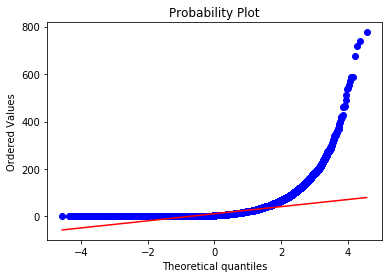

In [14]:
scipy.stats.probplot(df_exp.n_clicks, dist="norm", plot=pylab)
pylab.show()

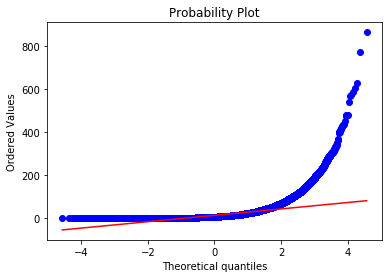

In [15]:
scipy.stats.probplot(df_control.n_clicks, dist="norm", plot=pylab)
pylab.show()

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп,
чтобы понять, как распределены среднее значение и выборочная дисперсия.

In [16]:
np.random.seed(0)
n_boot_samples = 500

In [126]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [128]:
samples=get_bootstrap_samples(df_control.n_clicks.values, n_boot_samples)

In [131]:
samples_mean=np.mean(samples, axis=1)

In [139]:
samples_chi_squared=np.sum(np.square(samples-samples_mean.reshape(-1,1)),axis=1)/n_boot_samples

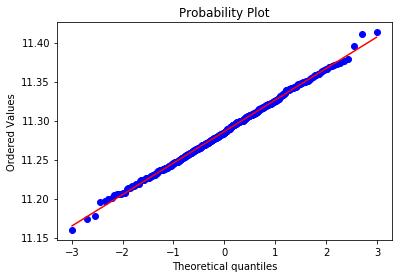

In [150]:
(_,_), (_,_,r)=scipy.stats.probplot(samples_mean, dist="norm", plot=pylab)
pylab.show()

In [153]:
print('R2 normal', np.square(r))

R2 normal 0.998389402505


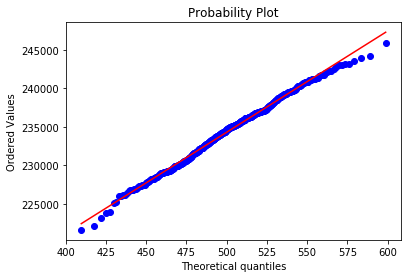

In [154]:
(_,_), (_,_,r)=scipy.stats.probplot(samples_chi_squared, dist="chi2", 
                     sparams=(n_boot_samples-1), plot=pylab)
pylab.show()

In [155]:
print('R2 che_squared', np.square(r))

R2 che_squared 0.99563756198


Преобразуем данные к виду, чтобы каждому пользователю соответствовало суммарное значение 
его кликов. С помощью критерия Манна-Уитни проверим гипотезу о равенстве средних. 

In [17]:
statistic, pvalue=scipy.stats.mannwhitneyu(df_exp.n_clicks, df_control.n_clicks,
                                           alternative='two-sided')

In [18]:
print('P-value mann whitneyu: ', pvalue)

P-value mann whitneyu:  8.69429437752e-75


Проверим для какого из браузеров наиболее сильно выражено отличие между количеством 
кликов в контрольной и экспериментальной группах.
Для этого применим для каждого из срезов (по каждому из уникальных значений столбца browser) 
критерий Манна-Уитни между control и exp группами и сделаем поправку Холма-Бонферрони на 
множественную проверку с α=0.05.

In [51]:
df_exp=df.loc[df['slot']=='exp',['browser','n_clicks','n_nonclk_queries','n_queries']]
df_control=df.loc[df['slot']=='control',['browser','n_clicks','n_nonclk_queries','n_queries']]

In [41]:
lst_browser=df_exp.browser.unique().tolist()

['Browser #2',
 'Browser #4',
 'Browser #14',
 'Browser #17',
 'Browser #20',
 'Browser #22']

In [44]:
lst_p=[]
for browser in lst_browser:
    browser_exp=df_exp.loc[df_exp['browser']==browser,'n_clicks'].values
    browser_control=df_control.loc[df_control['browser']==browser,'n_clicks'].values
    _, p=scipy.stats.mannwhitneyu(browser_exp,browser_control,alternative='two-sided')
    lst_p.append(p)

In [48]:
reject, p_corrected, a1, a2 = multipletests(lst_p,alpha = 0.05, method = 'holm')

In [49]:
p_corrected

array([ 0.2724386 ,  1.        ,  0.        ,  0.29920481,  1.        ,  1.        ])

In [50]:
lst_p

[0.054487720839448202,
 0.81521235316909968,
 0.0,
 0.074801202860216034,
 0.90733312777470754,
 0.51481103044200638]

In [59]:
exp_clicks=df_exp.groupby(['browser'])['n_nonclk_queries','n_queries'].sum()
control_clicks=df_control.groupby(['browser'])['n_nonclk_queries','n_queries'].sum()

In [60]:
exp_clicks['perc']=exp_clicks['n_nonclk_queries']/exp_clicks['n_queries']
control_clicks['perc']=control_clicks['n_nonclk_queries']/exp_clicks['n_queries']

In [61]:
exp_clicks['perc_control']=control_clicks['perc']
exp_clicks

,n_nonclk_queries,n_queries,perc,perc_control
browser,,,,
Browser #14,123656,282606,0.437556,0.570589
Browser #17,77614,210123,0.369374,0.360917
Browser #2,246514,548019,0.449827,0.474909
Browser #20,72998,187283,0.389774,0.419408
Browser #22,296177,743156,0.398539,0.424500
Browser #4,456508,1011250,0.451429,0.492711
